# [KerasCV] Image segmentation with a U-Net-like architecture

**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

This tutorial uses a U-Net like architecture for image segmentation. Data processing and
augmentations are implemented with [KerasCV](https://keras.io/keras_cv/).

U-Net was introduced in the paper,
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597/).
Although U-Net is a model for image
segmentation, it's also used in generative models such as Pix2Pix and diffusion models.
So it's important to have a solid understanding of its architecture.

## Setup and Imports

First let's set up install and imports of the dependencies.

To run this tutorial, you will need to install keras-cv with the following command:
`pip install keras-cv`

In [2]:
!pip install keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.7 MB/s eta 0:00:00


In [3]:
import random

import keras
import keras_cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

Using TensorFlow backend


## Configuration

Please feel free to tweak the configurations yourself and note how the model training
changes. This is an excellent exercise to get a better understanding of the training
pipeline.

In [4]:
# Image Config
HEIGHT = 160
WIDTH = 160
NUM_CLASSES = 3

# Augmentation Config
ROTATION_FACTOR = (-0.2, 0.2)

# Training Config
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE

## Download the data

We download
[the Oxford-IIT Pet dataset](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)
with TensorFlow
Datasets (TFDS) with one line of code. Combine the training and test data, and then split
the combined data into 80% training dataset and 20% test dataset (used later on for both
validation and testing).

In [5]:
tfds.disable_progress_bar()
orig_train_ds, orig_val_ds = tfds.load(
    name="oxford_iiit_pet",
    split=["train+test[:80%]", "test[80%:]"],
)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Preprocess the data

Here we processes the images and segmentation masks in the inputs **dictionary**, mapping
the image pixel intensities from `[0, 255]` to the range `[0.0, 1.0]` and adjusting
segmentation masks indices from 1-based to 0-based.

Also note the renaming of the keys of the dictionary. The processed datasets are
formatted suitably for KerasCV layers, which expect inputs in a specific dictionary
format.

In [6]:
rescale_images_and_correct_masks = lambda inputs: {
    "images": tf.cast(inputs["image"], dtype=tf.float32) / 255.0,
    "segmentation_masks": inputs["segmentation_mask"] - 1,
}

train_ds = orig_train_ds.map(
    rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE
)
val_ds = orig_val_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)

## Utility Function

The `unpackage_inputs` is a utility function that is used to unpack the inputs from the
dictionary format to a tuple of `(images, segmentation_masks)`. This will be used later
on for visualizing the images and segmentation masks and also the model predictions.

In [7]:

def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks


Let's visualized a few images and their segmentation masks from the training data, with
the `keras_cv.visualization.plot_segmentation_mask_gallery` API.

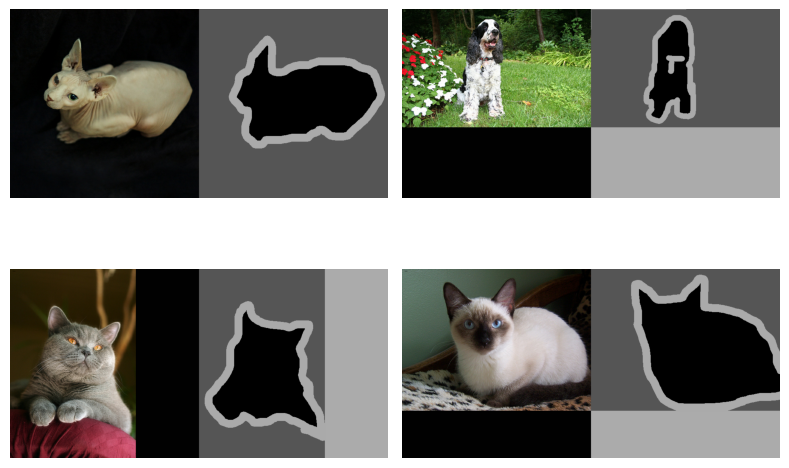

In [8]:
plot_train_ds = train_ds.map(unpackage_inputs).ragged_batch(4)
images, segmentation_masks = next(iter(plot_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

## Data Augmentation

We resize both the images and masks to the width/height as specified. Then use KerasCV's
`RandomFlip`, `RandomRotation` and `RandAugment` to apply image augmentation of random
flip, random rotation and RandAugment to the train dataset. Here is
[a tutorial with more details on RandAugment](https://keras.io/examples/vision/randaugment/).

We only apply the resizing operation to the validation dataset

In [14]:
resize_fn = keras_cv.layers.Resizing(
    HEIGHT,
    WIDTH,
)

augment_fn = keras.Sequential(
    [
        resize_fn,
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomRotation(
            factor=ROTATION_FACTOR,
            segmentation_classes=NUM_CLASSES,
        ),
        #keras_cv.layers.RandAugment(
        #    value_range=(0, 1),
        #    geometric=False,
        #),
    ]
)

Create training and validation datasets.

In [15]:
augmented_train_ds = (
    train_ds.shuffle(BATCH_SIZE * 2).map(augment_fn, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).map(unpackage_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)
)
resized_val_ds = (
    val_ds.map(resize_fn, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).map(unpackage_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

Now let's again visualize a few of the images and their segmentation masks with the
`keras_cv.visualization.plot_segmentation_mask_gallery` API. Note the effects from the
data augmentation.

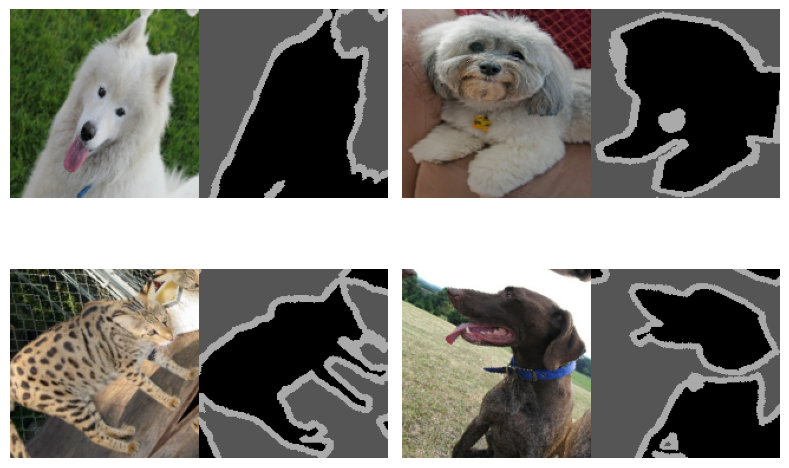

In [16]:
images, segmentation_masks = next(iter(augmented_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

## Model architecture

The U-Net consists of an encoder for downsampling and a decoder for upsampling with skip
connections.

The model architecture shapes like the letter U hence the name U-Net.

![unet.png](https://i.imgur.com/PgGRty2.png)

We create a function `get_model` to define a U-Net like architecture.

In [17]:

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Taking a batch of test inputs to measure model's progress.
test_images, test_masks = next(iter(resized_val_ds))


We subclass `Callback` to monitor the model training progress: training and validation
loss, and visually inspect the images, predicted masks and ground truth masks.

In [18]:

class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            pred_masks = self.model.predict(test_images)
            pred_masks = tf.math.argmax(pred_masks, axis=-1)
            pred_masks = pred_masks[..., tf.newaxis]

            # Randomly select an image from the test batch
            random_index = random.randint(0, BATCH_SIZE - 1)
            random_image = test_images[random_index]
            random_pred_mask = pred_masks[random_index]
            random_true_mask = test_masks[random_index]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
            ax[0].imshow(random_image)
            ax[0].set_title(f"Image: {epoch:03d}")

            ax[1].imshow(random_true_mask)
            ax[1].set_title(f"Ground Truth Mask: {epoch:03d}")

            ax[2].imshow(random_pred_mask)
            ax[2].set_title(
                f"Predicted Mask: {epoch:03d}",
            )

            plt.show()
            plt.close()


callbacks = [DisplayCallback(5)]

## Train the model

Now let's create the model, compile and train it for 50 epochs by calling `model.fit()`.

Epoch 1/50
4/4 [==============================] - 2s 36ms/step


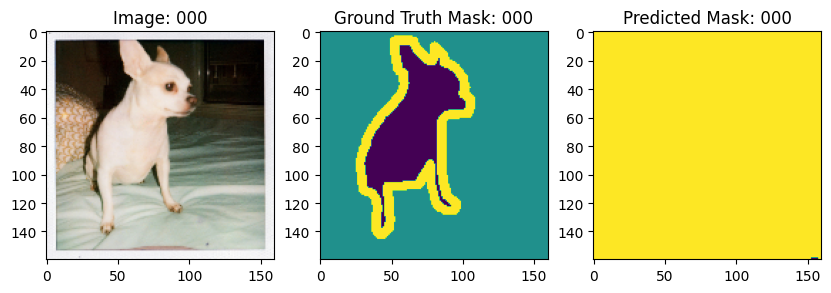

52/52 [==============================] - 138s 2s/step - loss: 1.3396 - accuracy: 0.6249 - val_loss: 1.6495 - val_accuracy: 0.5738
Epoch 2/50
52/52 [==============================] - 91s 2s/step - loss: 0.8410 - accuracy: 0.6795 - val_loss: 2.6229 - val_accuracy: 0.5739
Epoch 3/50
52/52 [==============================] - 96s 2s/step - loss: 0.7580 - accuracy: 0.6996 - val_loss: 3.0939 - val_accuracy: 0.5740
Epoch 4/50
52/52 [==============================] - 92s 2s/step - loss: 0.7175 - accuracy: 0.7116 - val_loss: 3.7598 - val_accuracy: 0.5740
Epoch 5/50
52/52 [==============================] - 93s 2s/step - loss: 0.6921 - accuracy: 0.7203 - val_loss: 4.0379 - val_accuracy: 0.5740
Epoch 6/50
4/4 [==============================] - 0s 47ms/step


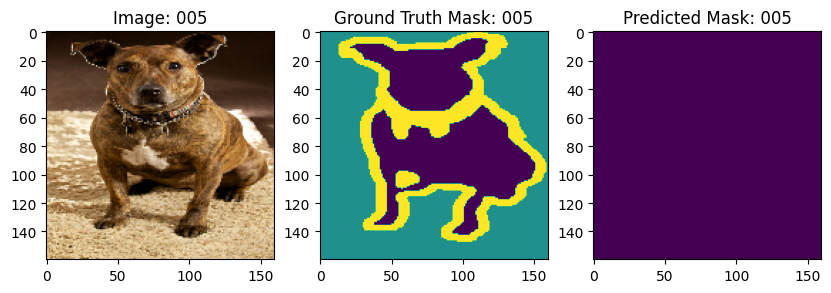

52/52 [==============================] - 92s 2s/step - loss: 0.6692 - accuracy: 0.7283 - val_loss: 3.9574 - val_accuracy: 0.5740
Epoch 7/50
52/52 [==============================] - 93s 2s/step - loss: 0.6522 - accuracy: 0.7347 - val_loss: 3.4968 - val_accuracy: 0.5740
Epoch 8/50
52/52 [==============================] - 90s 2s/step - loss: 0.6391 - accuracy: 0.7398 - val_loss: 3.3405 - val_accuracy: 0.5740
Epoch 9/50
52/52 [==============================] - 91s 2s/step - loss: 0.6239 - accuracy: 0.7453 - val_loss: 2.5150 - val_accuracy: 0.5740
Epoch 10/50
52/52 [==============================] - 93s 2s/step - loss: 0.6156 - accuracy: 0.7488 - val_loss: 1.5748 - val_accuracy: 0.5769
Epoch 11/50
4/4 [==============================] - 0s 62ms/step


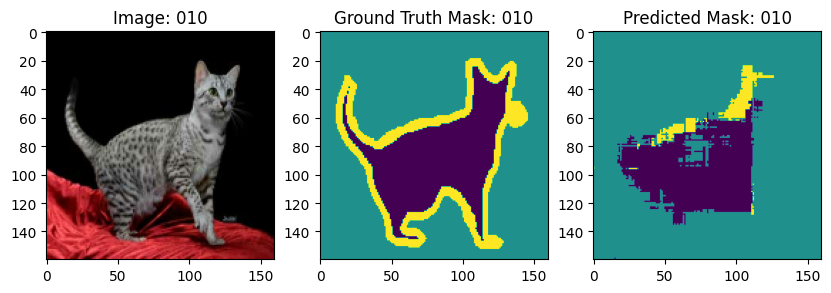

52/52 [==============================] - 94s 2s/step - loss: 0.6045 - accuracy: 0.7531 - val_loss: 0.9575 - val_accuracy: 0.6388
Epoch 12/50
52/52 [==============================] - 95s 2s/step - loss: 0.5958 - accuracy: 0.7571 - val_loss: 0.7085 - val_accuracy: 0.7200
Epoch 13/50
52/52 [==============================] - 91s 2s/step - loss: 0.5882 - accuracy: 0.7604 - val_loss: 0.6085 - val_accuracy: 0.7546
Epoch 14/50
52/52 [==============================] - 91s 2s/step - loss: 0.5797 - accuracy: 0.7635 - val_loss: 0.6215 - val_accuracy: 0.7526
Epoch 15/50
52/52 [==============================] - 93s 2s/step - loss: 0.5705 - accuracy: 0.7674 - val_loss: 0.5942 - val_accuracy: 0.7614
Epoch 16/50
4/4 [==============================] - 0s 47ms/step


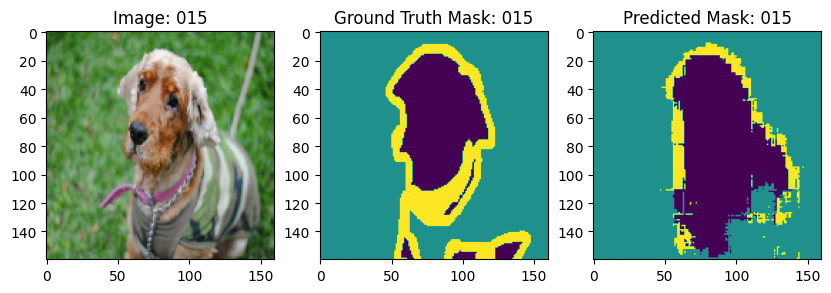

52/52 [==============================] - 92s 2s/step - loss: 0.5614 - accuracy: 0.7714 - val_loss: 0.5843 - val_accuracy: 0.7668
Epoch 17/50
52/52 [==============================] - 93s 2s/step - loss: 0.5567 - accuracy: 0.7734 - val_loss: 0.5660 - val_accuracy: 0.7741
Epoch 18/50
52/52 [==============================] - 92s 2s/step - loss: 0.5510 - accuracy: 0.7760 - val_loss: 0.5622 - val_accuracy: 0.7752
Epoch 19/50
52/52 [==============================] - 91s 2s/step - loss: 0.5472 - accuracy: 0.7779 - val_loss: 0.5844 - val_accuracy: 0.7706
Epoch 20/50
52/52 [==============================] - 92s 2s/step - loss: 0.5444 - accuracy: 0.7788 - val_loss: 0.5454 - val_accuracy: 0.7829
Epoch 21/50
4/4 [==============================] - 0s 46ms/step


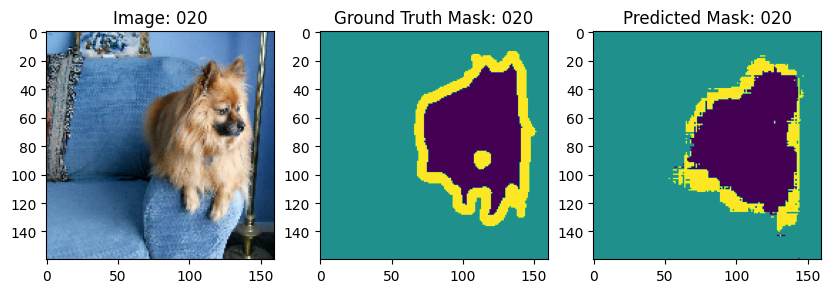

52/52 [==============================] - 92s 2s/step - loss: 0.5363 - accuracy: 0.7821 - val_loss: 0.5465 - val_accuracy: 0.7804
Epoch 22/50
52/52 [==============================] - 92s 2s/step - loss: 0.5289 - accuracy: 0.7850 - val_loss: 0.6189 - val_accuracy: 0.7597
Epoch 23/50
52/52 [==============================] - 94s 2s/step - loss: 0.5239 - accuracy: 0.7875 - val_loss: 0.5170 - val_accuracy: 0.7918
Epoch 24/50
52/52 [==============================] - 92s 2s/step - loss: 0.5204 - accuracy: 0.7888 - val_loss: 0.5394 - val_accuracy: 0.7864
Epoch 25/50
52/52 [==============================] - 93s 2s/step - loss: 0.5177 - accuracy: 0.7899 - val_loss: 0.5341 - val_accuracy: 0.7861
Epoch 26/50
4/4 [==============================] - 0s 46ms/step


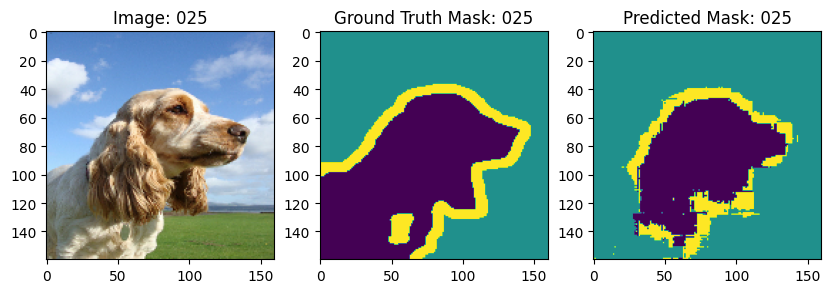

52/52 [==============================] - 93s 2s/step - loss: 0.5096 - accuracy: 0.7931 - val_loss: 0.5318 - val_accuracy: 0.7887
Epoch 27/50
52/52 [==============================] - 93s 2s/step - loss: 0.5074 - accuracy: 0.7940 - val_loss: 0.5092 - val_accuracy: 0.7963
Epoch 28/50
52/52 [==============================] - 94s 2s/step - loss: 0.5040 - accuracy: 0.7956 - val_loss: 0.5156 - val_accuracy: 0.7944
Epoch 29/50
52/52 [==============================] - 92s 2s/step - loss: 0.5003 - accuracy: 0.7973 - val_loss: 0.5397 - val_accuracy: 0.7874
Epoch 30/50
52/52 [==============================] - 96s 2s/step - loss: 0.4957 - accuracy: 0.7993 - val_loss: 0.5174 - val_accuracy: 0.7943
Epoch 31/50
4/4 [==============================] - 0s 61ms/step


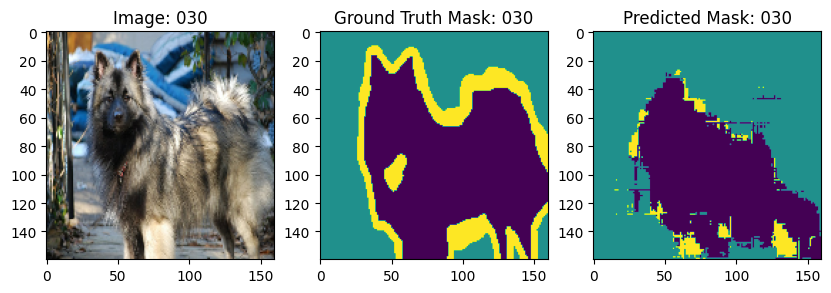

52/52 [==============================] - 95s 2s/step - loss: 0.4914 - accuracy: 0.8004 - val_loss: 0.5282 - val_accuracy: 0.7917
Epoch 32/50
52/52 [==============================] - 92s 2s/step - loss: 0.4908 - accuracy: 0.8013 - val_loss: 0.5212 - val_accuracy: 0.7951
Epoch 33/50
52/52 [==============================] - 94s 2s/step - loss: 0.4843 - accuracy: 0.8040 - val_loss: 0.5006 - val_accuracy: 0.8009
Epoch 34/50
52/52 [==============================] - 93s 2s/step - loss: 0.4797 - accuracy: 0.8065 - val_loss: 0.5186 - val_accuracy: 0.7927
Epoch 35/50
52/52 [==============================] - 94s 2s/step - loss: 0.4795 - accuracy: 0.8059 - val_loss: 0.4884 - val_accuracy: 0.8044
Epoch 36/50
4/4 [==============================] - 0s 46ms/step


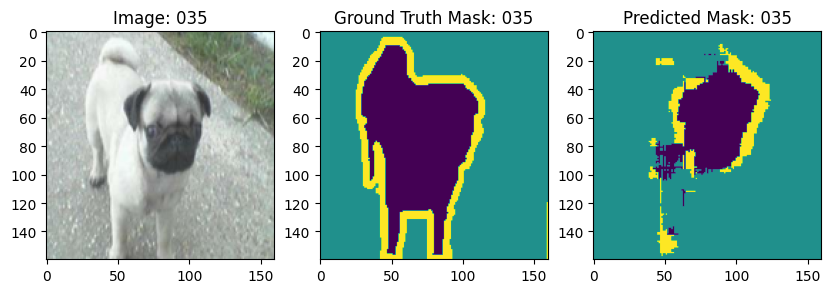

52/52 [==============================] - 92s 2s/step - loss: 0.4747 - accuracy: 0.8081 - val_loss: 0.5040 - val_accuracy: 0.8005
Epoch 37/50
52/52 [==============================] - 91s 2s/step - loss: 0.4734 - accuracy: 0.8083 - val_loss: 0.4950 - val_accuracy: 0.8025
Epoch 38/50
52/52 [==============================] - 93s 2s/step - loss: 0.4709 - accuracy: 0.8096 - val_loss: 0.5105 - val_accuracy: 0.7971
Epoch 39/50
52/52 [==============================] - 92s 2s/step - loss: 0.4660 - accuracy: 0.8117 - val_loss: 0.5336 - val_accuracy: 0.7935
Epoch 40/50
52/52 [==============================] - 93s 2s/step - loss: 0.4650 - accuracy: 0.8119 - val_loss: 0.4922 - val_accuracy: 0.8043
Epoch 41/50
4/4 [==============================] - 0s 47ms/step


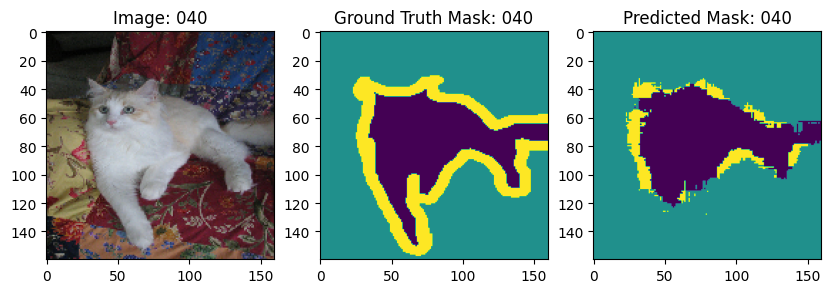

52/52 [==============================] - 93s 2s/step - loss: 0.4608 - accuracy: 0.8143 - val_loss: 0.4925 - val_accuracy: 0.8048
Epoch 42/50
52/52 [==============================] - 93s 2s/step - loss: 0.4580 - accuracy: 0.8152 - val_loss: 0.5133 - val_accuracy: 0.7982
Epoch 43/50
52/52 [==============================] - 94s 2s/step - loss: 0.4580 - accuracy: 0.8151 - val_loss: 0.4914 - val_accuracy: 0.8048
Epoch 44/50
52/52 [==============================] - 92s 2s/step - loss: 0.4541 - accuracy: 0.8170 - val_loss: 0.4762 - val_accuracy: 0.8114
Epoch 45/50
52/52 [==============================] - 92s 2s/step - loss: 0.4489 - accuracy: 0.8190 - val_loss: 0.4860 - val_accuracy: 0.8090
Epoch 46/50
4/4 [==============================] - 0s 47ms/step


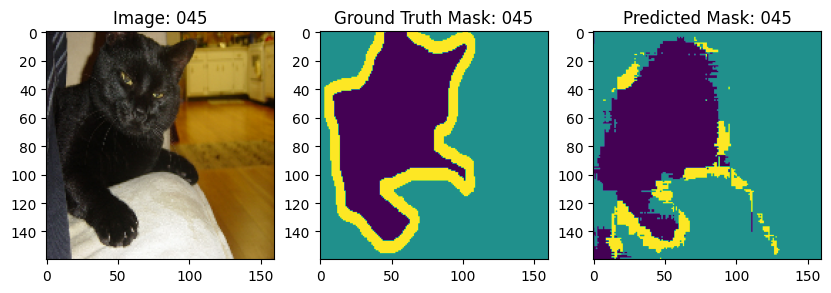

52/52 [==============================] - 95s 2s/step - loss: 0.4512 - accuracy: 0.8177 - val_loss: 0.4880 - val_accuracy: 0.8065
Epoch 47/50
52/52 [==============================] - 93s 2s/step - loss: 0.4516 - accuracy: 0.8177 - val_loss: 0.4775 - val_accuracy: 0.8117
Epoch 48/50
52/52 [==============================] - 92s 2s/step - loss: 0.4448 - accuracy: 0.8206 - val_loss: 0.4601 - val_accuracy: 0.8177
Epoch 49/50
52/52 [==============================] - 93s 2s/step - loss: 0.4429 - accuracy: 0.8213 - val_loss: 0.5221 - val_accuracy: 0.7993
Epoch 50/50
52/52 [==============================] - 92s 2s/step - loss: 0.4397 - accuracy: 0.8225 - val_loss: 0.4583 - val_accuracy: 0.8172


In [19]:
# Build model
model = get_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model, doing validation at the end of each epoch.
history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS,
    validation_data=resized_val_ds,
    callbacks=callbacks,
)

## Prediction with trained model
Now that the model training of U-Net has completed, let's test it by making predications
on a few sample images.

In [ ]:
pred_masks = model.predict(test_images)
pred_masks = tf.math.argmax(pred_masks, axis=-1)[..., None]

keras_cv.visualization.plot_segmentation_mask_gallery(
    test_images,
    value_range=(0, 1),
    num_classes=3,
    y_true=test_masks,
    y_pred=pred_masks,
    scale=4,
    rows=2,
    cols=2,
)

4/4 [==============================] - 0s 78ms/step
